# Practical Six: Semantic Segmentation

This notebook will introduce you to semantic segmentation in PyTorch. We will use pre-trained models available from [PyTorch Hub](https://pytorch.org/hub/), and model design and training are not within the scope of our course.

### References
* [PyTorch](https://pytorch.org/)
* [PyTorch Hub](https://pytorch.org/hub/)
* [Deeplabv3 (Content Credit)](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/)
* [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)

In [110]:
import torch
from torchvision import transforms
from PIL import Image, ImageChops, ImageFilter
import numpy as np

## Semantic Segmentation using DeepLabV3

Input RGB Image            |  Semantic Segmentation
:-------------------------:|:-------------------------:
![](../figs/deeplab1.png)  |  ![](../figs/deeplab2.png)

### Load a semantic segmentation model from PyTorch Hub

We will use DeepLabV3 models with ResNet-50 (`deeplabv3_resnet50`), ResNet-101 (`deeplabv3_resnet101`) and MobileNet-V3 (`deeplabv3_mobilenet_v3_large`) backbones from [PyTorch Hub](https://pytorch.org/hub/).

### Model Description

Deeplabv3-ResNet is constructed by a Deeplabv3 model using a ResNet-50 or ResNet-101 backbone.
Deeplabv3-MobileNetV3-Large is constructed by a Deeplabv3 model using the MobileNetV3 large backbone.
The pre-trained model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

|    Model structure           |   Mean IoU  | Global Pixelwise Accuracy |
| ---------------------------- | ----------- | --------------------------|
| deeplabv3_resnet50           |   66.4      |   92.4                    |
| deeplabv3_resnet101          |   67.4      |   92.4                    |
| deeplabv3_mobilenet_v3_large |   60.3      |   91.2                    |

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Using cache found in C:\Users\kjell/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\kjell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kjell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes with the following indexes `{'background':0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5, 'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'dining table':11, 'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'potted plant':16, 'sheep':17, 'sofa':18, 'train':19, 'tv/monitor':20}`. `output['out']` contains the semantic masks, and `output['aux']` contains the auxiliary loss values per-pixel. In inference mode, `output['aux']` is not useful. So, `output['out']` is of shape `(N, 21, H, W)` with

More documentation can be found [here](https://pytorch.org/vision/stable/models.html#semantic-segmentation).

### Test the semantic segmentation model on a sample image

In [8]:
filename = '../data/deeplab1.png'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

In [9]:
# the list of all possible objects in the input image
objects = {
    0:'background',
    1:'aeroplane',
    2:'bicycle',
    3:'bird',
    4:'boat',
    5:'bottle',
    6:'bus',
    7:'car',
    8:'cat',
    9:'chair',
    10:'cow',
    11:'dining table',
    12:'dog',
    13:'horse',
    14:'motorbike',
    15:'person',
    16:'potted plant',
    17:'sheep',
    18:'sofa',
    19:'train',
    20:'tv/monitor'
}

print('The list of the objects in the image:')
for output_prediction in output_predictions.unique():
    print(objects[output_prediction.item()])

The list of the objects in the image:
background
person
sheep


The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class. To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that displays the predictions, with each color being assigned to each class (see the visualized image on the left).

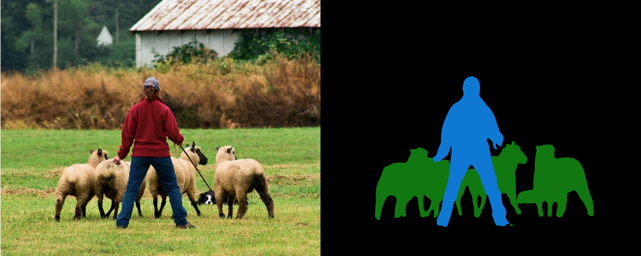

In [10]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# display the semantic segmentation predictions of 21 classes in each color
semantic_image = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
semantic_image.putpalette(colors)

concat_image = Image.new('RGB', 
                         (input_image.width + semantic_image.width, 
                          max(input_image.height, semantic_image.height)), 
                         color=(0, 0, 0))

concat_image.paste(input_image, (0, 0))
concat_image.paste(semantic_image, (input_image.width, 0))
(width, height) = (concat_image.width // 4, concat_image.height // 4)
display(concat_image.resize((width, height)))

### Removing objects from the image

We can use semantic segmentation for a variety of applications. For instance, we can now remove pixels of particular objects from the input image. Here removing a pixel means simply making it the background. The following function does that.

In [27]:
def remove_object_pixels(model, input_image, objects_to_remove, show_object_list=False, concat=False, scale=1):
    """
    This function removes the pixels of the objects listed in 'objects_to_remove' from the input 'input_image'
    using the semantic segmentation 'model' and returns the modified image.
    """
    model.eval()
    
    preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    
    objects = {
        0:'background',
        1:'aeroplane',
        2:'bicycle',
        3:'bird',
        4:'boat',
        5:'bottle',
        6:'bus',
        7:'car',
        8:'cat',
        9:'chair',
        10:'cow',
        11:'dining table',
        12:'dog',
        13:'horse',
        14:'motorbike',
        15:'person',
        16:'potted plant',
        17:'sheep',
        18:'sofa',
        19:'train',
        20:'tv/monitor'
    }
    
    objects_segmented = {}
    
    for output_prediction in output_predictions.unique().tolist():
        objects_segmented[output_prediction] = objects[output_prediction]
    
    if show_object_list:
        print(f'objects: {list(objects_segmented.values())}')
        
    mask = torch.zeros_like(output_predictions, dtype=torch.uint8)
    
    for key in objects_segmented.keys():
        if objects_segmented[key] not in objects_to_remove:
            index = (output_predictions == key)
            mask[index] = 255
            
    mask = transforms.ToPILImage()(mask).convert('RGB')
    
    masked_image = ImageChops.multiply(input_image, mask)
    
    output_image = masked_image.copy()
    
    if concat:
        output_image = Image.new('RGB', (input_image.width + masked_image.width, max(input_image.height, masked_image.height)))
        output_image.paste(input_image, (0, 0))
        output_image.paste(masked_image, (input_image.width, 0))
    
    if int(scale) > 1:
        (width, height) = (output_image.width // int(scale), output_image.height // int(scale))
        output_image = output_image.resize((width, height))
            
    return output_image

Now, we can test our function.

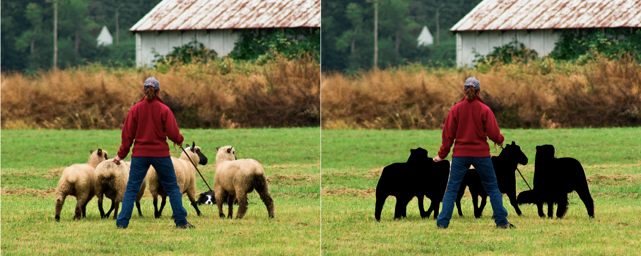

In [28]:
filename = '../data/deeplab1.png'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['sheep'], concat=True, scale=4)
display(output_image)

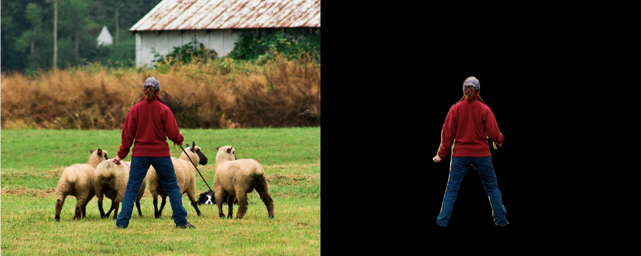

In [13]:
output_image = remove_object_pixels(model, input_image, ['sheep','background'], concat=True, scale=4)
display(output_image)

objects: ['background', 'bus', 'person']


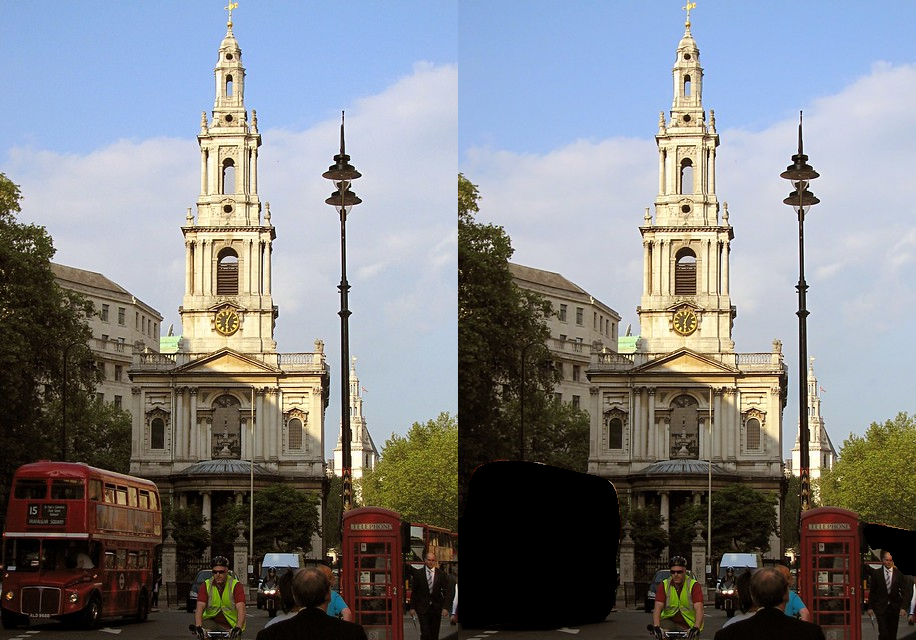

In [14]:
filename = '../data/deeplab2.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['bus'], show_object_list=True, concat=True, scale=1)
display(output_image)

objects: ['background', 'person', 'potted plant']


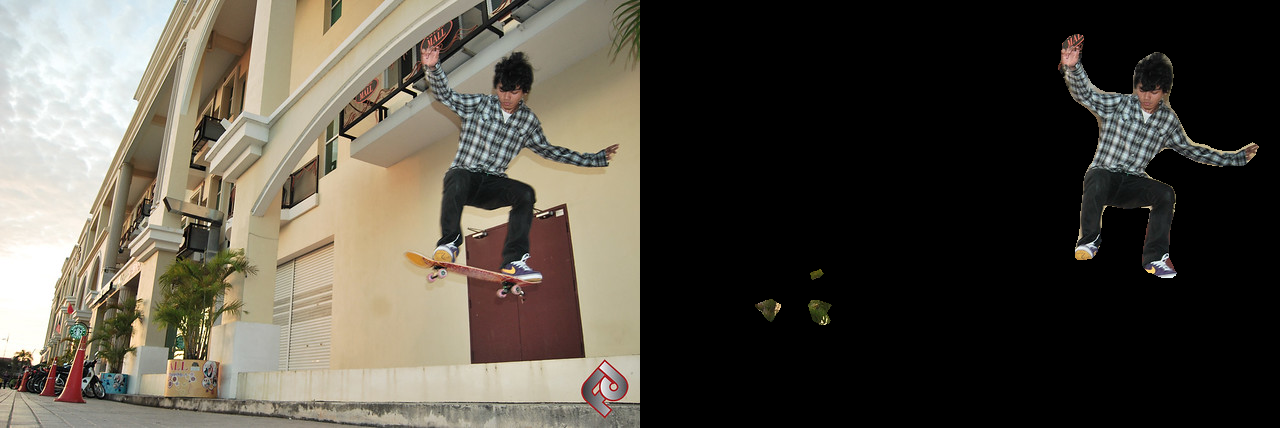

In [15]:
filename = '../data/deeplab3.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['background'], show_object_list=True, concat=True, scale=1)
display(output_image)

objects: ['background', 'bicycle', 'motorbike', 'person']


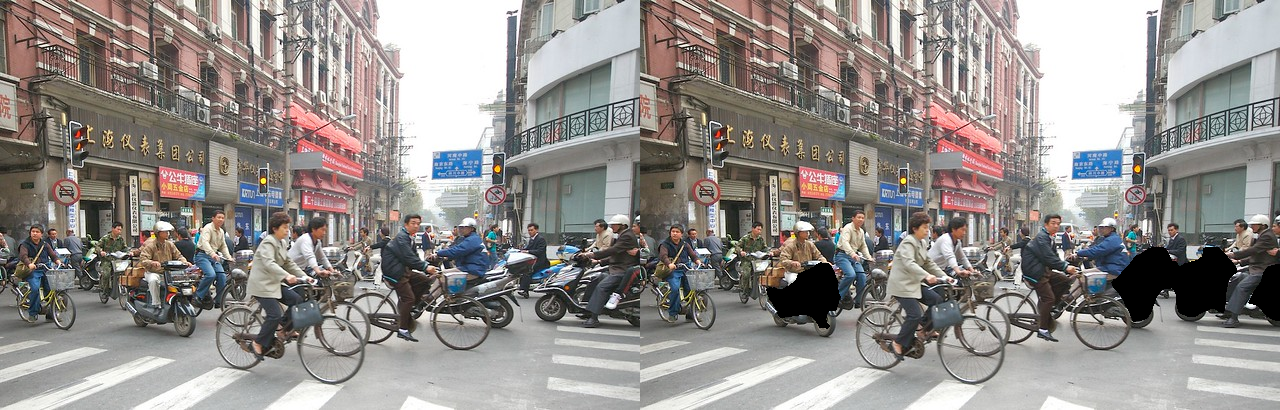

In [16]:
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['motorbike'], show_object_list=True, concat=True, scale=1)
display(output_image)

###  Bluring objects in the image

#### Your Task [30 Marks]

Another application of semantic segmentation is blurring image regions that belong to specific objects. For instance, the Google Street View Map application blurs human faces and vehicle license plates to protect privacy. Your task is to complete the function blur_object_pixels(...) to blur the pixels of specific objects provided by the user instead of removing them. The function should take the amount of blur as an input parameter. You may use isotropic Gaussian kernel of size $21 \times 21$ with a variable standard deviation to blur the image regions. See the function prototype below.

In [202]:
def blur_object_pixels(model, input_image: Image, objects_to_blur, sigma=1.0, show_object_list=False, concat=False, scale=1):
    """
    This function blurs the pixels of the objects listed in 'objects_to_blur' on the input 'input_image'
    using the semantic segmentation 'model' and returns the modified image. The amount of blur is
    controlled by the parameter 'sigma'.
    """
    
    model.eval()

    preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')


    with torch.no_grad():
        output = model(input_batch)['out'][0]

    output_predictions = output.argmax(0)

    objects = {
        0:'background',
        1:'aeroplane',
        2:'bicycle',
        3:'bird',
        4:'boat',
        5:'bottle',
        6:'bus',
        7:'car',
        8:'cat',
        9:'chair',
        10:'cow',
        11:'dining table',
        12:'dog',
        13:'horse',
        14:'motorbike',
        15:'person',
        16:'potted plant',
        17:'sheep',
        18:'sofa',
        19:'train',
        20:'tv/monitor'
    }

    objects_segmented = {}
    
    for output_prediction in output_predictions.unique().tolist():
        objects_segmented[output_prediction] = objects[output_prediction]
    
    if show_object_list:
        print(f'objects: {list(objects_segmented.values())}')
    
    processed_image: Image = input_image.copy()
    
    # ImageFilter does not support a sigma parameter
    blurred_image: Image = input_image.filter(ImageFilter.GaussianBlur(21))

    # Loop through all pixels in output_predictions
    for y in range(0, output_predictions.size(0)):
        for x in range(0, output_predictions.size(1)):
            key = output_predictions[y, x].item()

            if objects_segmented[key] in objects_to_blur:
                blurred_pixel = blurred_image.getpixel((x, y))
                processed_image.putpixel((x, y), blurred_pixel)
    
    output_image = processed_image.copy()

    if concat:
        output_image = Image.new('RGB', (input_image.width + processed_image.width, max(input_image.height, processed_image.height)))
        
        output_image.paste(input_image, (0, 0))
        output_image.paste(processed_image, (input_image.width, 0))
    
    if int(scale) > 1:
        (width, height) = (output_image.width // int(scale), output_image.height // int(scale))
        output_image = output_image.resize((width, height))
            
    return output_image

> [Important note] I think there are a bug in the task, where the function does not blur the bicycle in image4. The proposed solution blurs both the bicycle and the person.

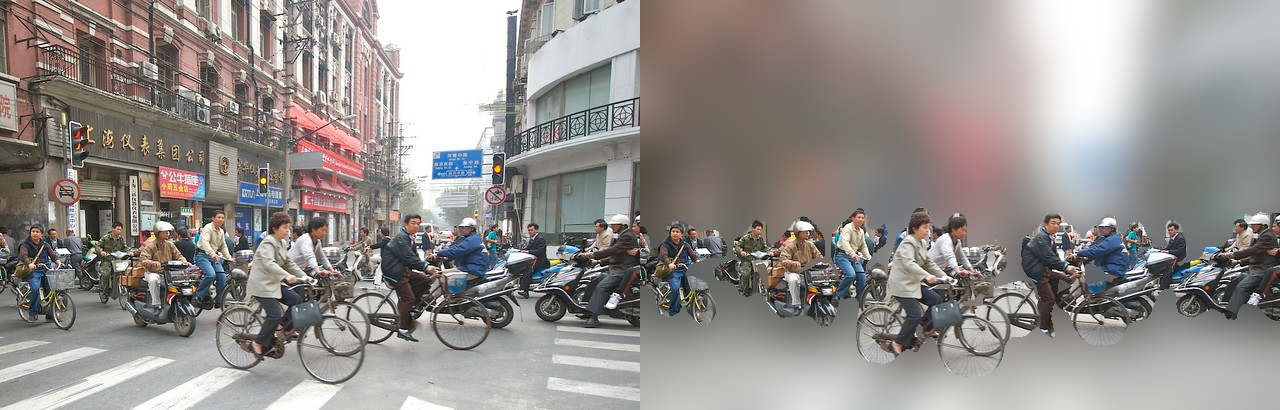

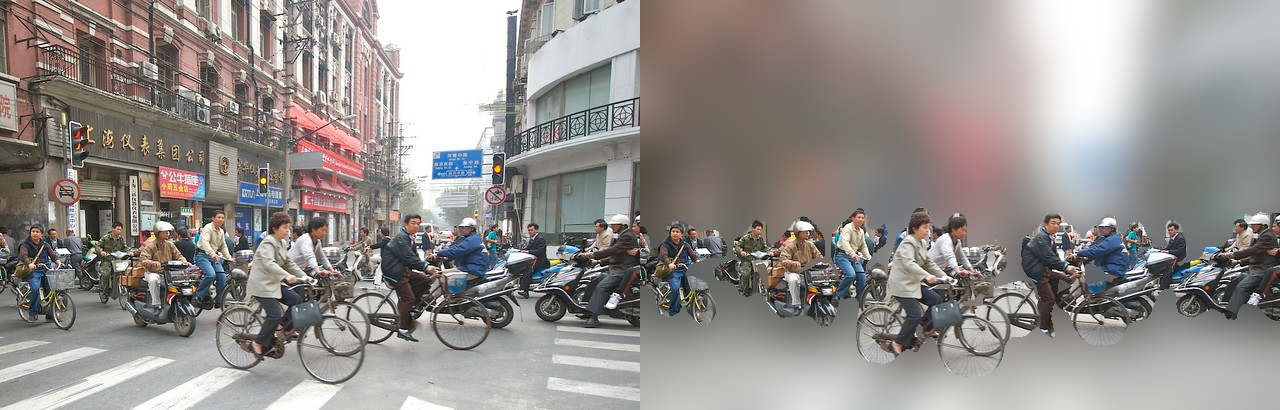

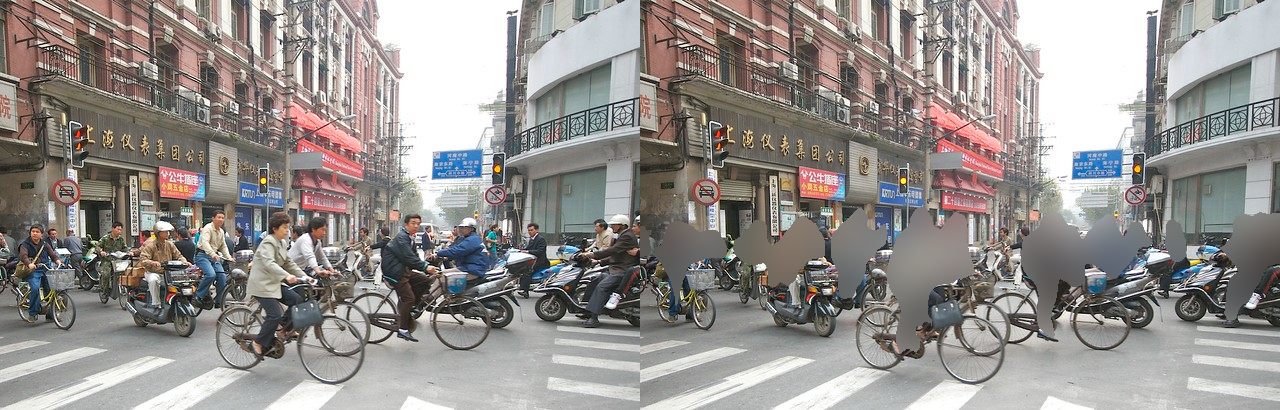

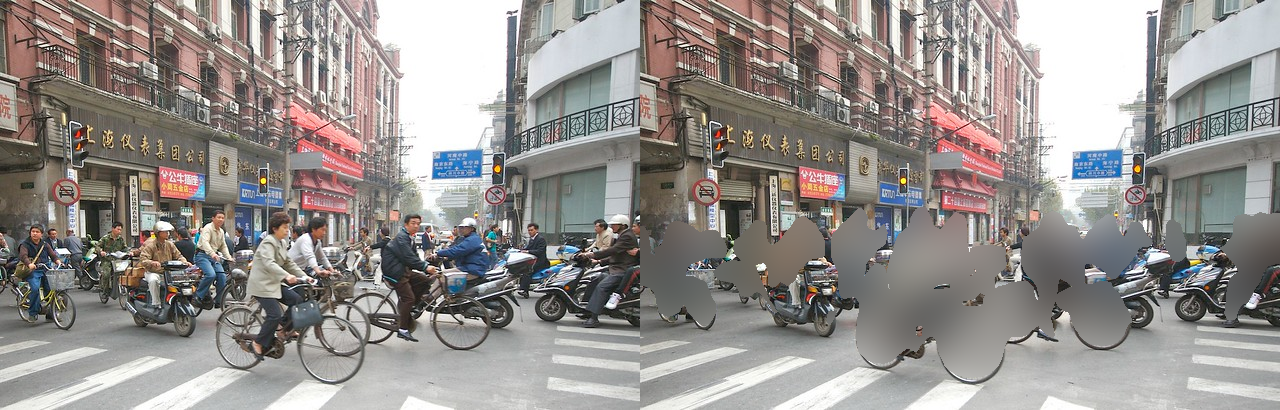

In [203]:
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")

output_image = blur_object_pixels(model, input_image, ['background'], sigma=5, show_object_list=False, concat=True, scale=1)
display(output_image)

output_image = blur_object_pixels(model, input_image, ['background'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)

output_image = blur_object_pixels(model, input_image, ['person'], sigma=3, show_object_list=False, concat=True, scale=1)
display(output_image)

output_image = blur_object_pixels(model, input_image, ['person','bicycle'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)

With all this working you should be able to create the following outputs for the given code snippets:
```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['background'], sigma=5, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_1.png)

```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['background'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_2.png)

```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['person'], sigma=3, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_3.png)

```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['person','bicycle'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_4.png)

### Evaluating the performances of DeepLabV3 models

#### Your Task [30 Marks]

Use DeepLabV3 models with ResNet-50 (`deeplabv3_resnet50`), ResNet-101 (`deeplabv3_resnet101`) and MobileNet-V3 (`deeplabv3_mobilenet_v3_large`) backbones from [PyTorch Hub](https://pytorch.org/hub/) on sample images under the `../data/` folder and compare their performances in terms of computing times and segmentation accuracy.

#### Test results

In terms of computing times, i have tested each model running each model through the four images.

I have repeated this operations several times, to verify that the variance in times is valid and not caused by other factos. 

The following list contains some result, starting with the fastest model.
 
- Model 3 (MobileNet-V3 backbone) an average processing time: 0.22330468893051147 seconds
- Model 1 (ResNet-50 backbone) with an average processing time: 1.3679229617118835 seconds
- Model 2 (ResNet-101 backbone) with an average processing time: 2.2451893091201782 seconds

It is clear that the MobileNet-V3 is much more efficient that the others.

As of testing for segmentation accuracy, i was not sure how to do this when there is no baseline segmentation mask.

In [134]:
import time

### Helper functions ###

# Preprocess the files in the same way as previosly done 
def preprocess_files(files):
    images = []
    for filename in files:
        input_image = Image.open(filename)
        input_image = input_image.convert("RGB")

        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)
        images.append(input_batch)

    return images

def run_segmentation(model, images):

    # Ensure model is in evaluation mode
    model.eval()

    processing_times = []
    pred_masks = []

    for image in images:

        if torch.cuda.is_available():
            image = image.to('cuda')
            model = model.to('cuda')
        
        start_time = time.time()

        with torch.no_grad():
            output = model(image)['out'][0]

        processing_times.append(time.time() - start_time)

        pred_mask = output.argmax(0)
        pred_masks.append(pred_mask)

    return processing_times, output_predictions

# Paths to the different files to use for testing
files = ['../data/deeplab1.png', '../data/deeplab2.jpg', '../data/deeplab3.jpg', '../data/deeplab4.jpg']

preprocessed_files = preprocess_files(files)

# Load the models
model_1 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model_2 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model_3 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)

model_1_processing_times, model_1_predictions = run_segmentation(model_1, preprocessed_files)
model_2_processing_times, model_2_predictions = run_segmentation(model_2, preprocessed_files)
model_3_processing_times, model_3_predictions = run_segmentation(model_3, preprocessed_files)

# Display the results
print('Model 1 (ResNet-50 backbone)')
print(f'Average processing time: {np.mean(model_1_processing_times)} seconds')

print('Model 2 (ResNet-101 backbone)')
print(f'Average processing time: {np.mean(model_2_processing_times)} seconds')

print('Model 3 (MobileNet-V3backbone)')
print(f'Average processing time: {np.mean(model_3_processing_times)} seconds')

Using cache found in C:\Users\kjell/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\kjell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kjell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\kjell/.cache\torch\hub\pytorch_vision_v0.10

Model 1 (ResNet-50 backbone)
Average processing time: 1.3710392713546753 seconds
Model 2 (ResNet-101 backbone)
Average processing time: 2.1745718121528625 seconds
Model 3 (MobileNet-V3backbone)
Average processing time: 0.20889240503311157 seconds


### Another application of semantic segmentation

#### Your Task [40 Marks]

Find another application of semantic segmentation and provide a brief description of why you decided to choose this specific application. Then, use DeepLabV3 model with ResNet-50 (`deeplabv3_resnet50`) backbone from [PyTorch Hub](https://pytorch.org/hub/) to implement the application and demonstrate your implementation in this notebook. Note that the originality of the application will get high marks.

#### Solution and implementation

There are a lot of different use-cases for this, but i found it found it difficult to find a application. I landed on implementing something humous and topical, so i hope you can se the humor in the application of choice.

The proposed application uses semantic segmentation to blur pictures of norwegian ministers who have been caught cheating on their master thesis, performing tax evasion and other normal criminal activities for norwegian ministers. The application will be a useful tool for the government to use, as they quite frequently need to swap out ministers performing such activities.

The application should be combined with some form of object identification to detect the appropriate minister in photos so not blameless ministers (if any exist) dont get swapped out. As object identification is out of scope for this lab, the solution is to place a potted plant next to the minister that is suspected to have violated a law or policy. 

#### Implementation
The implementation builds uppon the code from the blurring-exercise but adds a search for potted plants nearby the detected person. The function `ìs_nearby_potted_plant` searches for a detected potted-plant within `distance` from a given pixel. If the pixel is within the distance from a potted plant it is blurred.

In [190]:
def is_nearby_potted_plant(output_predictions, distance, x, y):
    # First we calculate the area around the given pixel that should be included in the search
    # We do this by finding the min and max values on both axis
    x_min = max(0, x - distance)
    x_max = min(output_predictions.size(1), x + distance)
    y_min = max(0, y - distance)
    y_max = min(output_predictions.size(0), y + distance)

    # We then take a subset of the predictions that are within the 
    # square of min and max values

    subset_of_predictions = output_predictions[y_min:y_max, x_min:x_max]

    # If 16 (potted plant class) is in the subset, then return True
    if 16 in subset_of_predictions.unique().tolist():
        return True

    # Else, return false    
    return False

def blur_minister_if_nearby_potted_plant(model, input_image: Image, distance = 100):
    model.eval()

    preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model = model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]

    output_predictions = output.argmax(0)

    objects = {
        0:'background',
        1:'aeroplane',
        2:'bicycle',
        3:'bird',
        4:'boat',
        5:'bottle',
        6:'bus',
        7:'car',
        8:'cat',
        9:'chair',
        10:'cow',
        11:'dining table',
        12:'dog',
        13:'horse',
        14:'motorbike',
        15:'person',
        16:'potted plant',
        17:'sheep',
        18:'sofa',
        19:'train',
        20:'tv/monitor'
    }

    objects_segmented = {}
    
    for output_prediction in output_predictions.unique().tolist():
        objects_segmented[output_prediction] = objects[output_prediction]
    
    processed_image: Image = input_image.copy()
    
    # ImageFilter does not support a sigma parameter
    blurred_image: Image = input_image.filter(ImageFilter.GaussianBlur(21))

    # Loop through all pixels in output_predictions
    for y in range(0, output_predictions.size(0)):
        for x in range(0, output_predictions.size(1)):
            key = output_predictions[y, x].item()

            # Check if there is a potted-plant less than 100 pixels away from the current pixel (x, y)
            is_nearby_plant = is_nearby_potted_plant(output_predictions, distance, x, y)

            if objects_segmented[key] in ['person'] and is_nearby_plant:
                blurred_pixel = blurred_image.getpixel((x, y))
                processed_image.putpixel((x, y), blurred_pixel)
    
    output_image = processed_image.copy()

    return output_image



##### Examples
Example 1 does not blur any minister, because it no potted plant is placed nearby.
Example 2 blurs the minister.

Using cache found in C:\Users\kjell/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\kjell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kjell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


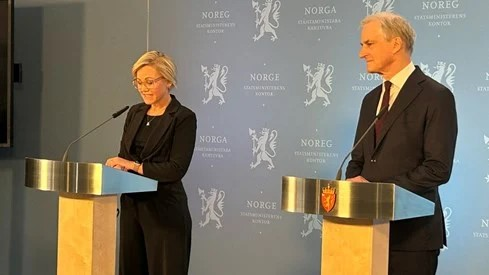

In [191]:
filename = '../data/ministers.jpg'

input_image = Image.open(filename)
input_image = input_image.convert("RGB")

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

output_image = blur_minister_if_nearby_potted_plant(model, input_image)
display(output_image)

Using cache found in C:\Users\kjell/.cache\torch\hub\pytorch_vision_v0.10.0


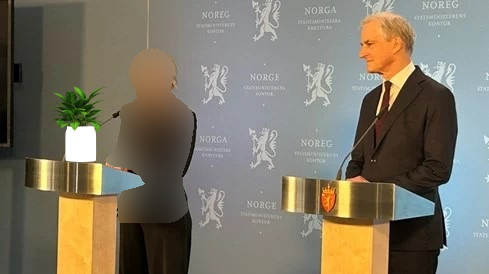

In [192]:
filename = '../data/ministers_plant.jpg'

input_image = Image.open(filename)
input_image = input_image.convert("RGB")

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

output_image = blur_minister_if_nearby_potted_plant(model, input_image)
display(output_image)

# Submission

Answer the questions, zip your entire folder and submit it on Canvas under Assignment 6.